# Finding the parameters of Lotka-Volterra equations with Evolution Strategies

The Lotka-Volterra equations, named after Alfred Lotka and Vito Volterra, are a mathematical model for understanding how the populations of predator and prey species can influence each other's growth and evolution over time. The equations consist of two coupled first-order differential equations, one for the predator population ($Y$) and one for the prey population ($X$):

$$  \frac{dX}{dt} = rX - aXY $$

$$  \frac{dY}{dt} = -zY + bXY $$

Equations are defined by a set of parameters, such as $r$, $a$, $z$, and $b$, in the previous formulation.

The goal of this lab session is to find the parameters of a dynamic system defined by Lotka-Volterra equations leveraging **Evolution Strategies** (ES). We will consider having access to the trajectories corresponding to a single simulation.

First of all, let us import some useful modules and functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint #solver for a system of ordinary differential equations

random.seed(0)
np.random.seed(0)

Now, we want to write the code to actually perform the simulation and get our trajectories.  Let's define a function that, given the current state, the time instant, and the parameters, returns the derivatives calculated by the Lotka-Volterra equations. We don't know who is the prey and the predator a priori, the sign is given by the parameter itself!

In [2]:
# Define the Lotka-Volterra equations
def lotka_volterra(state, t, params):
    dx = params[0,0] * state[0] + params[0,1] * state[0] * state[1]
    dy = + params[1,0] * state[1] + params[1,1] * state[0] * state[1]
    return dx, dy

Now we arbitrarily choose the initial conditions of our simulation, a set of parameters and the time vector.

In [3]:
# Set the initial conditions and parameters
initial_conditions = [4, 2]  # Initial populations of species X and Y

real_params = np.array(
    [[0.5, -0.3],
    [-0.1, 0.2]],
)

# Create a time vector
t = np.linspace(0, 100, 1000)

# Solve the differential equations using odeint
solution = odeint(lotka_volterra, initial_conditions, t, args=(real_params,))

# Extract the populations of each species
x, y = solution.T

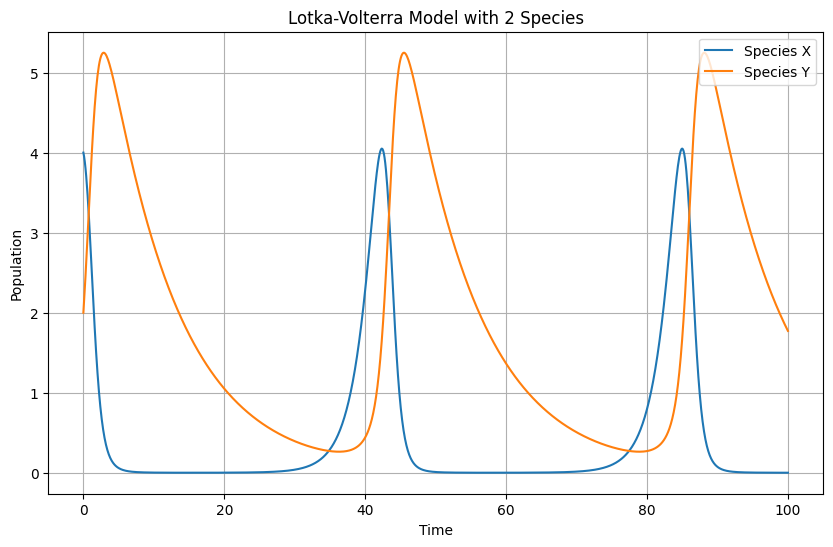

In [4]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Species X')
plt.plot(t, y, label='Species Y')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Model with 2 Species')
plt.grid(True)
plt.show()

Now, let's assume we don't know the parameters that generated the previous trajectories. We aim to find them using ES!

Define a fitness function which suits the problem. Each individual is a set of parameters for the Lotka-Volterra equations and we want to get as close as possible to the actual one through the evolution.

In [37]:
# Fitness function
class MSE_fit(object):
    
    def __init__(self, target_traj):
        self.target_traj = target_traj

    def eval(self, individual):
        t = np.linspace(0, 100, 1000)
        initial_conditions=self.target_traj[0]
        sol = odeint(lotka_volterra, initial_conditions, t, args=(individual,))
        return np.mean((sol - self.target_traj) ** 2)

Define a class for our ES. It must implement the One-Fifth Rule for variance self-adaptation. Implement a strategy of your choice for recombination.

In [14]:
def recombination(parents): # intermediate
    new_ind = np.mean(np.stack(parents), axis=0)
    return new_ind

In [26]:
class EvolutionStrategy(object):
    
    def __init__(self, mu, lmb, ro, fit, rec, individual_shape, limits, plus=False, initial_variance=1, k=10, c=0.5):
        self.mu = mu
        self.lmb = lmb
        self.ro = ro # param for recombination
        self.plus = plus
        self.fit = fit
        self.rec = rec #recombination strategy
        self.individual_shape = individual_shape
        self.limits = limits
        self.pop = []
        self.variance = initial_variance
        self.k = k # (the param for 1/5 rule, usually 1/5)
        self.c = c # in (0,1)
        self.k_counter = 0

        # Initialize the population
        for _ in range(self.lmb):
            individual = np.random.uniform(self.limits[0], self.limits[1], individual_shape)
            self.pop.append(individual)

        self.best = min(self.pop, key=self.fit)
        self.best_fit = self.fit(self.best)
    
    def generation(self):
        self.truncated_selection()
        new_pop = []
        for i in range(0, self.lmb):
            parents = random.sample(self.pop, self.ro)
            new_ind = recombination(parents=parents)
            new_ind = self.mutation(new_ind)
            new_pop.append(new_ind)
        #if self.k_counter == self.k:
            # 1/5 rule
            # CODE HERE
        if self.plus:
            self.pop = self.pop + new_pop
        else:
            self.pop = new_pop
        candidate_best = min(self.pop, key=self.fit)
        if self.fit(self.best) > self.fit(candidate_best): 
            self.best = candidate_best
            self.best_fit = self.fit(self.best)
    
    def mutation(self, individual):
        for i in range(2):
            for j in range(2):
                tmp = individual[i, j] + random.gauss(0, self.variance)
                if self.limits[0] < tmp < self.limits[1]:
                    individual[i, j] = tmp
            
        return individual
    
    def truncated_selection(self):
        list.sort(self.pop, key=self.fit)
        self.pop = self.pop[0:self.mu]
        
    def __str__(self):
        s = f"Best individual: {self.best}\n"
        s += f"with fitness {self.fit(self.best)}"
        return s

Run the evolution and save the best fitness score for each generation.

In [39]:
mse = MSE_fit(target_traj=solution).eval

ES = EvolutionStrategy(50, 100, 2, mse, recombination, (2, 2), [-1, 1], k=20, plus=True)
history = [ES.best_fit]
n_gen = 300
for i in range(0, n_gen):
    ES.generation()
    history.append(ES.best_fit)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/var/folders/m2/r059lv3n7nq9x6gh78v25xk80000gn/T/ipykernel_18614/3156031798.py:11: RuntimeWarning: overflow encountered in square
  return np.mean((sol - self.target_traj) ** 2)


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1427091386344D+02   r2 =  0.8794827470800D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1427091386344D+02   r2 =  0.8794827470800D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1427091386344D+02   r2 =  0.7281964020494D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1427091386344D+02   r2 =  0.7281964020494D-15
 lsoda--  warning..internal t (=r1) 

Plot and visualize the results

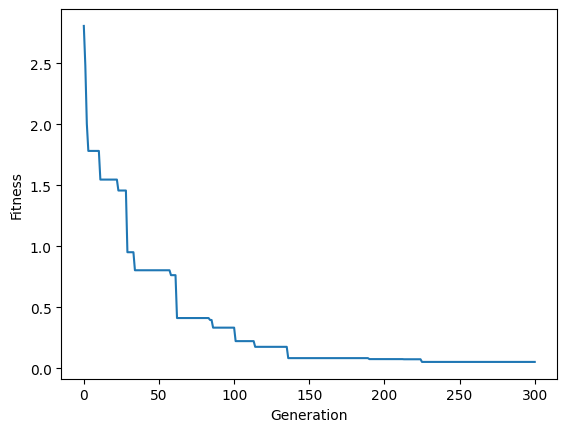

In [40]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.show()

In [41]:
res_best = odeint(lotka_volterra, initial_conditions, t, args=(ES.best,))

# Extract the populations of each species
x, y = res_best.T

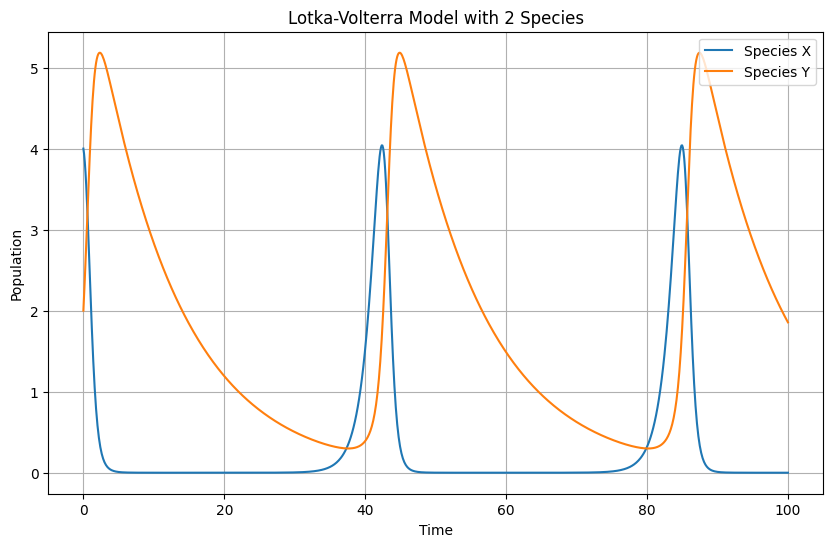

In [42]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, x, label='Species X')
plt.plot(t, y, label='Species Y')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Model with 2 Species')
plt.grid(True)
plt.show()

In [43]:
print(ES)

Best individual: [[ 0.75356501 -0.44001448]
 [-0.08658263  0.24496803]]
with fitness 0.05157590870910611
